In [1]:
#Petr
try:
    import google.colab
    COLAB = True
except ModuleNotFoundError:
    COLAB = False
    pass

if COLAB:
    !pip -q install "gymnasium[classic-control, atari, accept-rom-license]"
    !pip -q install piglet
    !pip -q install imageio_ffmpeg
    !pip -q install moviepy==1.0.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.8/953.8 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 11.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.5/67.5 kB 1.9 MB/s eta 0:00:00


In [2]:
import gymnasium as gym
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from functools import partial
from IPython.display import clear_output
from sklearn.decomposition import PCA
from collections import defaultdict

%matplotlib inline

In [3]:
MOVE_DIRECTIONS = {
    # (i, j)-based coordinates [or (y, x) for the viewer]
    'right': (0, 1), 'down': (1, 0), 'left': (0, -1), 'up': (-1, 0)
}
DIRECTIONS_ORDER = ['right', 'down', 'left', 'up']
TURN_DIRECTIONS = {'right': 1, 'left': -1}


class MoveDynamics:
    @staticmethod
    def try_move(
            position: tuple[int, int], move_direction: tuple[int, int],
            shape: tuple[int, int], obstacle_mask: np.ndarray
    ):
        """
        Performs the move if it's allowed.
        Returns new position and flag whether or not the move was successful.
        """
        new_position = MoveDynamics.move(position, move_direction)
        new_position = MoveDynamics.clip2d(new_position, shape)

        success = MoveDynamics.is_move_successful(position, new_position, obstacle_mask)
        if not success:
            new_position = position
        return new_position, success

    @staticmethod
    def is_move_successful(
            position: tuple[int, int], new_position: tuple[int, int],
            obstacle_mask: np.ndarray
    ):
        """Checks whether move is happened and is allowed."""
        # changed position but not stepped into the wall
        return new_position != position and not obstacle_mask[new_position]

    @staticmethod
    def move(position: tuple[int, int], direction: tuple[int, int]):
        """
        Calculates new position for the move to the specified direction
        without checking whether this move is allowed or not.
        """
        i, j = position
        i += direction[0]
        j += direction[1]
        return i, j

    @staticmethod
    def clip2d(position: tuple[int, int], shape: tuple[int, int]):
        """Clip position to be inside specified rectangle."""
        def clip(x, high):
            if x >= high:
                return high - 1
            if x < 0:
                return 0
            return x
        i, j = position
        i = clip(i, shape[0])
        j = clip(j, shape[1])
        return i, j


In [19]:
four_rooms_obstacles = """
-------x-------
-------x-------
-------x-------
---------------
-------x-------
-------x-------
-------x-------
xxx-xxxxxxx-xxx
-------x-------
-------x-------
-------x-------
---------------
-------x-------
-------x-------
-------x-------
"""
four_rooms_obstacles = np.array([
    [int(c == 'x') for c in row]
    for row in four_rooms_obstacles.strip().split('\n')
])
four_rooms_obstacles

array([[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]])

In [20]:
"""
----------------
----------------
--xxxxxxxxxxxxx-
--x-----------x-
--x-x-xxxxxxx-x-
--x-x-------x-x-
--x-x-xxxxx-x-x-
--x-x-x---x-x-x-
--x-x-x-x-x-x-x-
--x-x-x---x-x-x-
--x-x-xxx-x-x-x-
--x-x-------x-x-
--x-xxxxxxxxx-x-
--x-----------x-
--x-xxxxxxxxxxx-
----------------
----------------
"""

'\n----------------\n----------------\n--xxxxxxxxxxxxx-\n--x-----------x-\n--x-x-xxxxxxx-x-\n--x-x-------x-x-\n--x-x-xxxxx-x-x-\n--x-x-x---x-x-x-\n--x-x-x-x-x-x-x-\n--x-x-x---x-x-x-\n--x-x-xxx-x-x-x-\n--x-x-------x-x-\n--x-xxxxxxxxx-x-\n--x-----------x-\n--x-xxxxxxxxxxx-\n----------------\n----------------\n'

In [159]:
from __future__ import annotations
from numpy.random import Generator

TPos = tuple[int, int]
TSize2d = tuple[int, int]

class GridWorld:
    size: TSize2d
    init_agent_pos: TPos
    obstacles: np.ndarray

    agent_pos: TPos

    terminal: TPos
    reward: float
    const_punish: float
    terminal_decay: float
    time_limit: int | None

    pixel_size: int
    color_map: dict

    _pos: TPos
    _obs: np.ndarray
    _step: int
    _terminated: bool
    _next_pos_cache: dict[tuple[TPos, int], TPos]

    def __init__(
        self,
        *,
        size: TSize2d,
        agent_pos: TPos = None,
        obstacle_mask: np.ndarray = None,
        terminal: TPos = None,
        reward: float = None,
        const_punish: float = 0.,
        terminal_decay: float = 1.0,
        time_limit: int = None,
        pixel_size: int = 1,
        color_map: dict = None,
    ):
        self.size = size
        self.init_agent_pos = agent_pos

        self.obstacles = np.zeros(self.size, dtype=int)
        if obstacle_mask is not None:
            self.obstacles[:] = obstacle_mask

        self.terminal = terminal
        self.reward = reward
        assert const_punish >= 0., 'I expect negative punish'
        self.const_punish = const_punish
        assert terminal_decay <= 1., 'I expect terminal reward decaying, i.e. terminal_decay <= 1.0'
        self.terminal_decay = terminal_decay

        self.time_limit = time_limit

        self.pixel_size = pixel_size
        self.color_map = color_map
        self.observation_space = size[0]*size[1]
        self.action_space = (4,)

        self._pos = self.init_agent_pos
        self._obs = self._get_initial_observation()
        self._next_pos_cache = {}
        self.reset()

    def reset(self):
        # do not forget to update observation
        #   1) regularly: old pos -> floor; init pos -> agent
        self._update_observation(self._pos, self.init_agent_pos)
        #   2) restore target if it was overwritten: terminal -> target
        self._fill(self.terminal, self.color_map['target'])

        self._pos = self.init_agent_pos
        self._step = 0
        self._terminated = self._is_current_pos_terminal()

        state_num = self._state_num()
        return state_num, dict(pos=self._pos, obs = self._obs)

    def step(self, action):
        assert not self._terminated

        self._step += 1
        self._pos = self._move(action)

        # move before getting the reward
        reward = self._get_reward()

        # update terminated state after getting the reward
        terminated = self._is_current_pos_terminal()
        truncated = self.time_limit is not None and self._step >= self.time_limit
        self._terminated = terminated or truncated

    #    return self._obs, reward, terminated, truncated, dict(pos=self._pos)
        state_num = self._state_num()
        return state_num, reward, terminated, truncated, dict(obs=self._obs, pos = self._pos)

    def render_rgb(self):
        plt.imshow(self._obs)

    def _is_current_pos_terminal(self) -> bool:
        return self._pos == self.terminal

    def _state_num(self):
        state_num = self.size[1] * self._pos[0] +  self._pos[1]
        return state_num

    def _get_reward(self) -> float:
        reward = 0
        if self._pos == self.terminal and not self._terminated:
            reward += self.terminal_decay ** self._step
        reward += self.const_punish
        return reward


    def _move(self, action) -> TPos:
        new_pos = self._next_pos_cache.get((self._pos, action), None)
        if new_pos is None:
            # call true dynamics to get new position
            new_pos, _ = MoveDynamics.try_move(
                position=self._pos,
                move_direction=MOVE_DIRECTIONS[DIRECTIONS_ORDER[action]],
                shape=self.size, obstacle_mask=self.obstacles
            )
            self._next_pos_cache[(self._pos, action)] = new_pos

        # update observation after move
        self._update_observation(self._pos, new_pos)
        return new_pos

    def _get_initial_observation(self) -> np.ndarray:
        # make observation map with pixel positions
        obs = np.zeros(self.size)
        obs[self.obstacles == 0] = self.color_map['floor']
        obs[self.obstacles == 1] = self.color_map['obstacle']
        obs[self.terminal] = self.color_map['target']
        obs[self._pos] = self.color_map['agent']

        # then resize observation transforming each pixel to the square
        px = self.pixel_size
        return np.repeat(np.repeat(obs, px, axis=0), px, axis=1)


    def _update_observation(self, pos, new_pos):
        # fill old pos with floor color, fill new pos with agent color
        px = self.pixel_size
        floor, agent = self.color_map['floor'], self.color_map['agent']

        self._fill(pos, floor)
        self._fill(new_pos, agent)

    def _fill(self, pos, color):
        # fill position with the color
        (i, j), px = pos, self.pixel_size
        i, j = i*px, j*px
        self._obs[i:i+px, j:j+px] = color

env = GridWorld(
    size=four_rooms_obstacles.shape,
    obstacle_mask=four_rooms_obstacles,
    agent_pos=(0, 0), terminal=(14,14),
    const_punish=0., terminal_decay=0.99,
    time_limit=50,
    pixel_size=2, color_map=dict(floor=.3, obstacle=.02, agent=.6, target=.9)
)

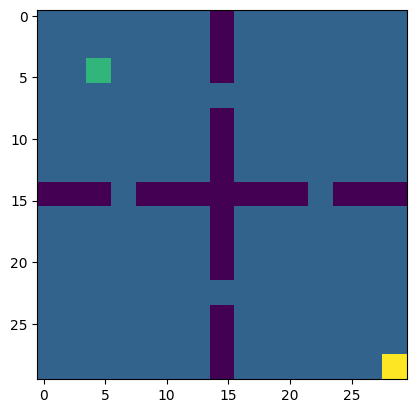

In [23]:
env.reset()
env.step(1)
env.step(0)
env.step(1)
env.step(0)
env.render_rgb()

In [25]:
def generate_session(env, steps, rng):
    if isinstance(rng, int):
        rng = np.random.default_rng(rng)

    env.reset()
    while steps >= 0:
        _, _, terminated, truncated, _ = env.step(rng.integers(4))
        if terminated or truncated:
            env.reset()
        steps -= 1

In [30]:
class DecayVal:
    val: float
    decay: float
    schedule: int
    def __init__(self, val, decay, schedule):
        self.val = val
        self.decay = decay
        self.i = 0
        self.schedule = schedule

    def __call__(self):
        return self.val

    def step(self):
        self.i += 1
        if self.i % self.schedule == 0:
            self.val *= self.decay

In [249]:
class Agent:
    def __init__(
            self,
            states_size: tuple,
            actions_size: tuple = (4,),
            gamma: float = 0.99,
            eps: float= 0.5,
            lr: float = 0.05,
            seed: int = 42,
    ) -> None:
        self.gamma = gamma
        self.eps = eps
        self.lr = lr
        self.rng = np.random.default_rng(seed)
        self.Q = np.zeros((states_size, actions_size))

    #epsilon greedy policy
    def policy(self, state):
        if self.rng.random() < self.eps():
            action = self.rng.integers(4)
        else:
            action = np.argmax(self.Q[state])
        return action

    def reset(self):
        self.eps.step()
        self.lr.step()

    #Q-learning update
    def update_policy(self, state, action, reward, next_state, done):
        # current Q
        q = self.Q[state, action]
        # next optimal Q, chosen in greedy fashion
        q_next = self.Q[next_state].max()
        # TD_error
        TD_error = reward + self.gamma*q_next - q
        # update Q-weights
        self.Q[state, action] += self.lr() * TD_error

        return TD_error

In [341]:
class AgentSR:
    def __init__(
            self,
            states_size: int,
            actions_size: int,
            gamma: float = 0.99,
            eps: float= 0.5,
            lr: float = 0.05,
            seed: int = 42,
    ) -> None:
        self.gamma = gamma
        self.eps = eps
        self.lr = lr
        self.rng = np.random.default_rng(seed)
        self.states_size = states_size
        self.actions_size = actions_size
        self.M = np.zeros((actions_size, states_size, states_size))
        self.R = np.zeros((states_size,))

    def policy(self, state):
        if self.rng.random() < self.eps():
            action = self.rng.choice(self.actions_size)
        else:
            action = np.argmax(np.matmul(self.M[:, state, :], self.R))
        return action

    def reset(self):
        self.eps.step()
        self.lr.step()


    def update_policy(self, state, action, reward, next_state, done):
        error_R = reward - self.R[next_state]
        self.R[next_state] += self.lr() * error_R

        a_next = self.policy(next_state)
        target = self.gamma * (1 - done) * self.M[a_next, next_state, :]
        target[next_state] += 1.0
        error_M = target - self.M[action, state,  :]
        self.M[action, state, :] += self.lr() * error_M

        return error_M

In [364]:
# использую вот этот
class AgentSR:
    def __init__(
            self,
            states_size: int,
            actions_size: int,
            gamma: float = 0.99,
            eps: float= 0.5,
            lr: float = 0.05,
            seed: int = 1337,
    ) -> None:
        self.gamma = gamma
        self.eps = eps
        self.lr = lr
        self.rng = np.random.default_rng(seed)
        self.states_size = states_size
        self.actions_size = actions_size
        self.M = np.zeros((states_size, actions_size, states_size))
        self.R = np.zeros((states_size,))

    def policy(self, state):
        if self.rng.random() < self.eps():
            action = self.rng.choice(self.actions_size)
        else:
            action = np.argmax(np.dot(self.M[state], self.R))
        return action

    def reset(self):
        self.eps.step()
        self.lr.step()


    def update_policy(self, state, action, reward, next_state, done):
        error_R = reward - self.R[next_state]
        self.R[next_state] += self.lr() * error_R

        a_next = self.policy(next_state)
        target = self.gamma * (1 - done) * self.M[next_state, a_next]
        target[next_state] += 1.0
        error_M = target - self.M[state, action]
        self.M[state, action] += self.lr() * error_M

        return error_M

In [336]:
class Trainer:

    def __init__(self,
                 environment,
                 agent,
                 name = "RL experiment",
                 seed: int = 42):
        self.name = name
        self.env = environment
        self.agent = agent
        self.rng = np.random.default_rng(seed)

    def get_agent(self):
        return self.agent

    def show_progress(self,**stats):

        """
        stats : dict <-- keys: "avg_returns",
        Удобная функция, которая отображает прогресс обучения.
        """
        clear_output(True)
        fig, ax = plt.subplots(2,2, figsize=[14, 6])
        fig.suptitle(self.name)
        ax[0, 0].plot(*zip(*stats["avg_returns"]))
        ax[0, 0].set_title('Mean return')
        ax[0, 0].grid()

        ax[0, 1].plot(*zip(*stats["lifetime_errors"]))
        ax[0, 1].set_title('TD errors')
        ax[0, 1].grid()

        ax[1, 0].plot(*zip(*stats["success_rate"]))
        ax[1, 0].set_title('Success rate')
        ax[1, 0].grid()

        ax[1, 1].plot(*zip(*stats["trajectory_lengths"]))
        ax[1, 1].set_title('Trajectory lengths')
        ax[1, 1].grid()

        plt.show()

    def train(self,
              num_episodes = 2000,
              eps = 1.0,
              success_rate_window = 20,
              show_progress_schedule = 50):
        self.agent.eps.val = eps

        lifetime_errors = []
        success_rate, success_batch = [], []
        trajectory_lengths = []
        experience = defaultdict(list)
        avg_returns, returns_batch = [], []

        for i in range(num_episodes):
            episodic_error = []
            state, _ = self.env.reset()
            #env.terminal = tuple(self.rng.choice([(14, 14), (0, 14)]))
            reward, episode_return = 0, 0
            time = 0
            while True:

                action = self.agent.policy(state)
                next_state, reward, terminated, truncated, misc = self.env.step(action)
                done = terminated or truncated

                point = dict(
                    state = state,
                    action = action,
                    reward = reward,
                    next_state = next_state,
                    misc = misc)
                experience[i].append(point)

                error = self.agent.update_policy(state, action, reward, next_state, done)
                time += 1
                episodic_error.append(np.mean(np.abs(error)))
                state = next_state
                episode_return += reward

                if done:
                    self.agent.reset()
                    break

            returns_batch.append(episode_return)
            trajectory_lengths.append((i,time))

            success_batch.append(terminated)
            if len(success_batch) == success_rate_window:
                success_rate.append((i, np.mean(success_batch)))
                success_batch = []

            lifetime_errors.append((i, np.mean(episodic_error)))

            if i % show_progress_schedule == 0:
                avg_returns.append((i, np.mean(returns_batch)))
                returns_batch = []

                self.show_progress(
                    avg_returns = avg_returns,
                    lifetime_errors = lifetime_errors,
                    success_rate = success_rate,
                    trajectory_lengths = trajectory_lengths,
                )
                print(
                    f"Episode: {i}, Return: {episode_return}, "
                    f"AvgReturn[{show_progress_schedule}]: {avg_returns[-1][1]:.0f}"
                )

        return {
            "lifetime_errors" : lifetime_errors,
            "success_rate": success_rate,
            "trajectory_lengths": trajectory_lengths,
            "experience": experience,
            "avg_returns": avg_returns,
        }

    def test(self,
              num_episodes = 2000,
              eps = 0.1,
              success_rate_window = 20,
              show_progress_schedule = 50):
        self.agent.eps.val = eps

        experience = defaultdict(list)
        success_rate, success_batch = [], []
        trajectory_lengths = []
        avg_returns, returns_batch = [], []

        for i in range(num_episodes):
            state, _ = self.env.reset()

            time = 0
            while True:
                reward, episode_return = 0, 0
                action = self.agent.policy(state)
                next_state, reward, terminated, truncated, misc = self.env.step(action)
                done = terminated or truncated

                point = dict(
                    state = state,
                    action = action,
                    reward = reward,
                    next_state = next_state,
                    misc = misc)
                time +=1

                state = next_state
                experience[i].append(point)
                episode_return += reward

                if done:
                    break

            trajectory_lengths.append((i,time))

            success_batch.append(terminated)
            if len(success_batch) == success_rate_window:
                success_rate.append((i,np.mean(success_batch)))
                success_batch = []

            if i % show_progress_schedule == 0:
                avg_returns.append((i, np.mean(returns_batch)))
                returns_batch = []

                clear_output(True)
                print(
                    f"Episode: {i}, Return: {episode_return}, "
                    f"AvgReturn[{show_progress_schedule}]: {avg_returns[-1][1]:.0f}"
                )

        return {
            "experience": experience,
            "success_rate": success_rate,
            "trajectory_lengths": trajectory_lengths,
            "avg_returns": avg_returns,
        }



In [319]:
env = GridWorld(
    size=four_rooms_obstacles.shape,
    obstacle_mask=four_rooms_obstacles,
    agent_pos=(0, 0), terminal=(14,14),
    const_punish=0., terminal_decay=0.99,
    time_limit=400,
    pixel_size=2, color_map=dict(floor=.3, obstacle=.02, agent=.6, target=.9)
)

agent = AgentSR(
    states_size=four_rooms_obstacles.shape[0]*four_rooms_obstacles.shape[1],
    actions_size= 4,
    gamma = 0.95,
    eps = DecayVal(1.0, decay=0.99, schedule=20),
    lr = DecayVal(0.5, decay=0.6, schedule=250),
)

trainer = Trainer(
    environment = env,
    agent = agent,
    name = "Tabular SR"
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


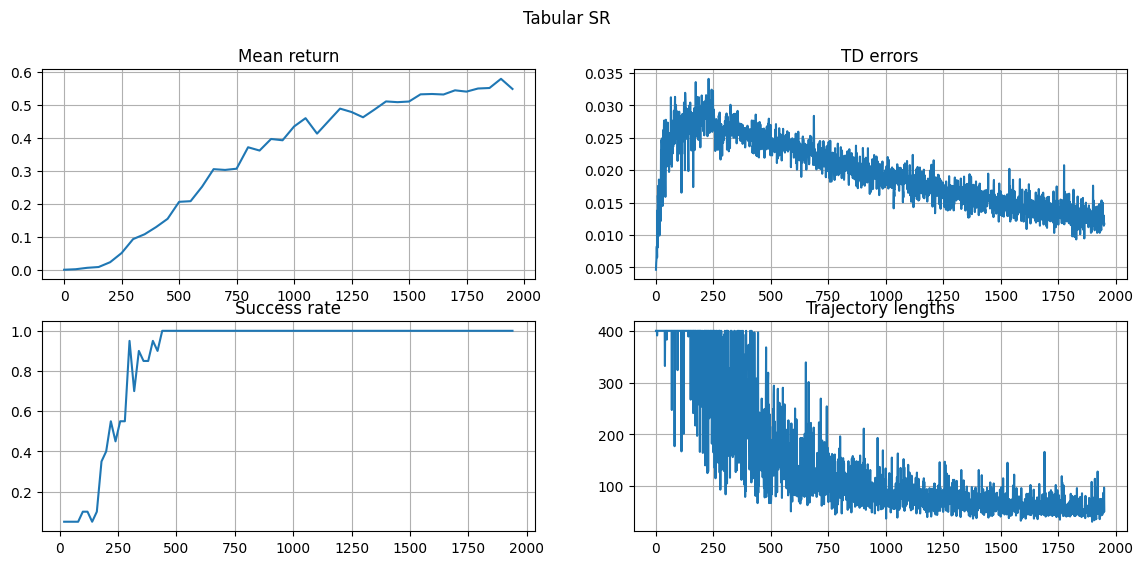

Episode: 1950, Return: 0.5929664464014994, AvgReturn[50]: 1


In [239]:
train_stats = trainer.train(eps = 1)

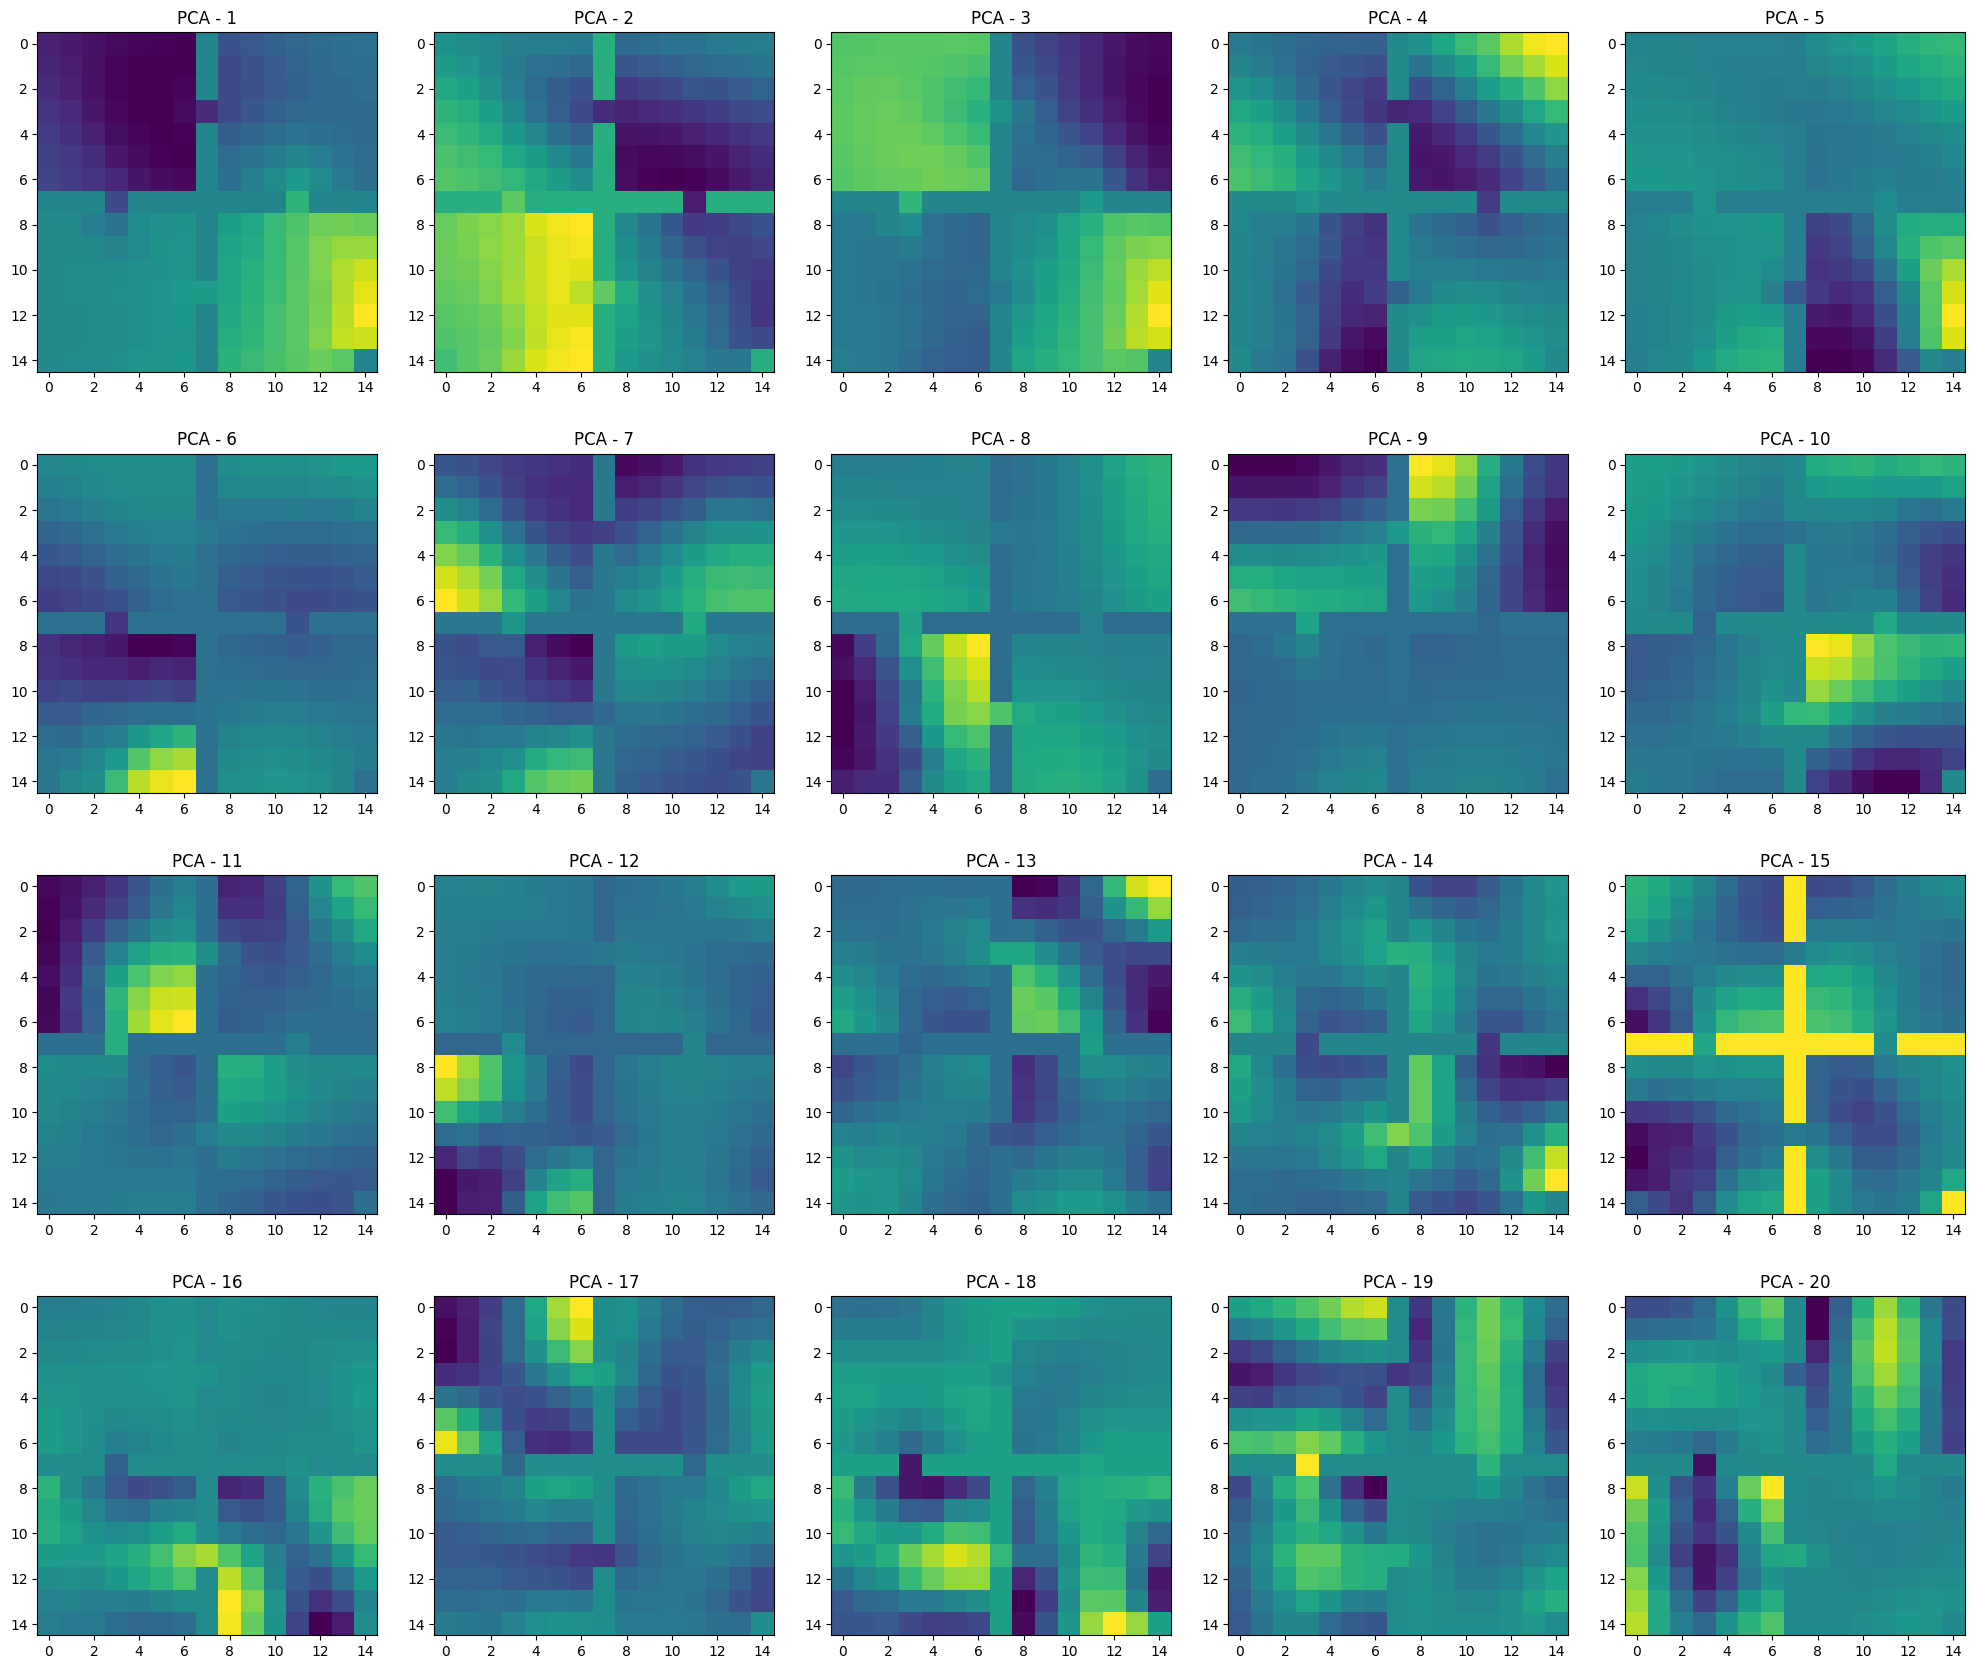

In [240]:
pca = PCA(n_components=100)
pca_M = pca.fit_transform(agent.M.mean(0))

n = 5
m = 4
fig, ax = plt.subplots(m,n, figsize = (20,17))
fig.tight_layout()

for i in range(m):
    for j in range(n):
        ax[i, j].imshow(pca_M[:,i*n + j].reshape(*env.size))
        #ax[i, j].imshow(agent.M.mean(0)[:, i*n + j].reshape(17,16))
        ax[i, j].set_title(f"PCA - {i*n + j+1}")

fig.show()

Text(0.5, 1.0, 'PCA 1 vs 2')

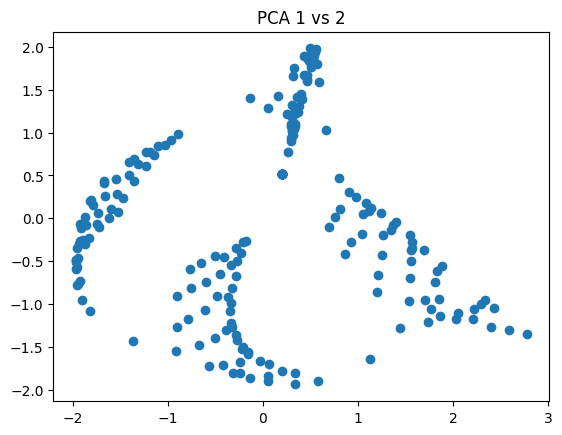

In [243]:
plt.scatter(pca_M[:,0], pca_M[:,1])
plt.title ("PCA 1 vs 2")

In [145]:
env.terminal = (14,14)
test_stats = trainer.test(eps = 0.1)

Episode: 1950, Return: 0.6298236312032323, AvgReturn[50]: nan


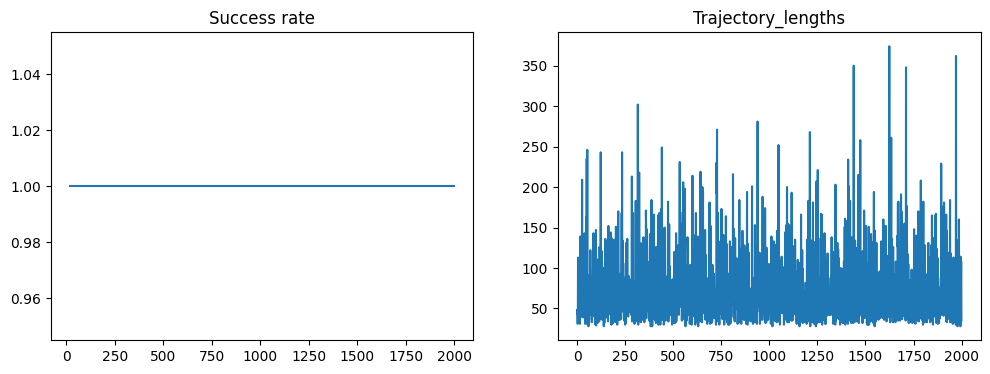

In [203]:
fig, ax = plt.subplots(1,2, figsize = (12,4))
ax[0].plot(*zip(*test_stats["success_rate"]))
ax[0].set_title("Success rate")

ax[1].plot(*zip(*test_stats["trajectory_lengths"]))
ax[1].set_title("Trajectory_lengths")

fig.show()

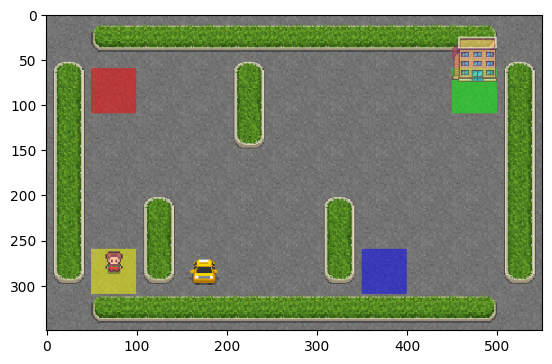

In [176]:
env = gym.make("Taxi-v3", render_mode="rgb_array")
env.reset(seed=13)
plt.imshow(env.render())

In [337]:
env = gym.make("Taxi-v3")
env.reset(seed=42)

agent = Agent(
    states_size=env.observation_space.n,
    actions_size=env.action_space.n,
    gamma = 0.95,
    eps = DecayVal(0.1, decay=0.97, schedule=100),
    lr = DecayVal(0.3, decay=0.8, schedule=250),
    seed = 1337,
)

trainer = Trainer(
    environment = env,
    agent = agent,
    name = "Tabular SR"
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [338]:
train_stats = trainer.train(num_episodes = 2500)

KeyboardInterrupt: ignored

<Figure size 1400x600 with 0 Axes>

In [359]:
env = gym.make("Taxi-v3")

agent = AgentSR(
    states_size=env.observation_space.n,
    actions_size=env.action_space.n,
    gamma = 0.95,
    eps = DecayVal(val=0.1, decay=0.97, schedule=100),
    lr = DecayVal(val=0.3, decay=0.8, schedule=250),
    seed = 1337
)

trainer = Trainer(
    environment = env,
    agent = agent,
    name = "Tabular SR"
)

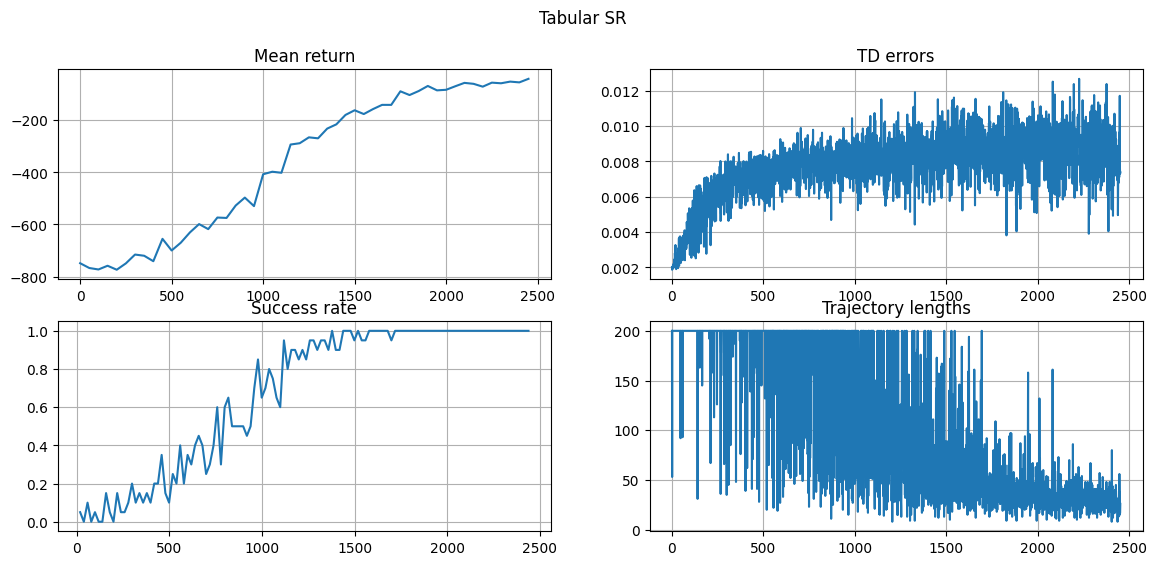

Episode: 2450, Return: -41, AvgReturn[50]: -41


In [360]:
train_stats = trainer.train(num_episodes = 2500)

In [361]:
class SrAgent:
    def __init__(self, n_states, n_actions, lr, gamma, eps, seed, sarsa=False):
        self.r = np.zeros((n_states,))
        self.M = np.zeros((n_states, n_actions, n_states))
        self.lr = lr
        self.gamma = gamma
        self.eps = eps
        self.n_actions = n_actions
        self.sarsa = sarsa
        self._rng = np.random.default_rng(seed)

    def reset(self):
        self.eps.step()
        self.lr.step()

    def Q(self, s):
        return np.dot(self.M[s], self.r)

    def policy(self, s, greedy=False):
        # выбираем действие, используя eps-greedy исследование среды
        # с вероятностью epsilon выбираем случайное действие, иначе
        # выполняем действие жадно, согласно текущей Q-таблице
        if not greedy and self._rng.random() < self.eps():
            action = self._rng.choice(self.n_actions)
        else:
            action = np.argmax(self.Q(s))  # используем Q-функцию
        return action

    def update_policy(self, s, a, r, s_n, done):
        # реализуйте шаг Q-обучения
        # получаем old_value (Q(s,a)) и next_max (max(Q(s', a')))
        self.r[s_n] += self.lr() * (r - self.r[s_n])

        # do I need max(M)?
        a_n = self.policy(s_n, greedy=not self.sarsa)

        target = self.gamma * (1 - done) * self.M[s_n, a_n]
        target[s_n] += 1.

        td_error = target - self.M[s,a]
        self.M[s, a] += self.lr() * td_error

        return td_error

In [362]:
env = gym.make("Taxi-v3")
seed = 1337
agent = SrAgent(
    env.observation_space.n, env.action_space.n, gamma=0.95, seed=seed,
    lr=DecayVal(val=0.1, decay=0.97, schedule=100),
    eps=DecayVal(val=0.3, decay=0.8, schedule=250),
    sarsa=False
)


trainer = Trainer(
    environment = env,
    agent = agent,
    name = "Tabular SR"
)

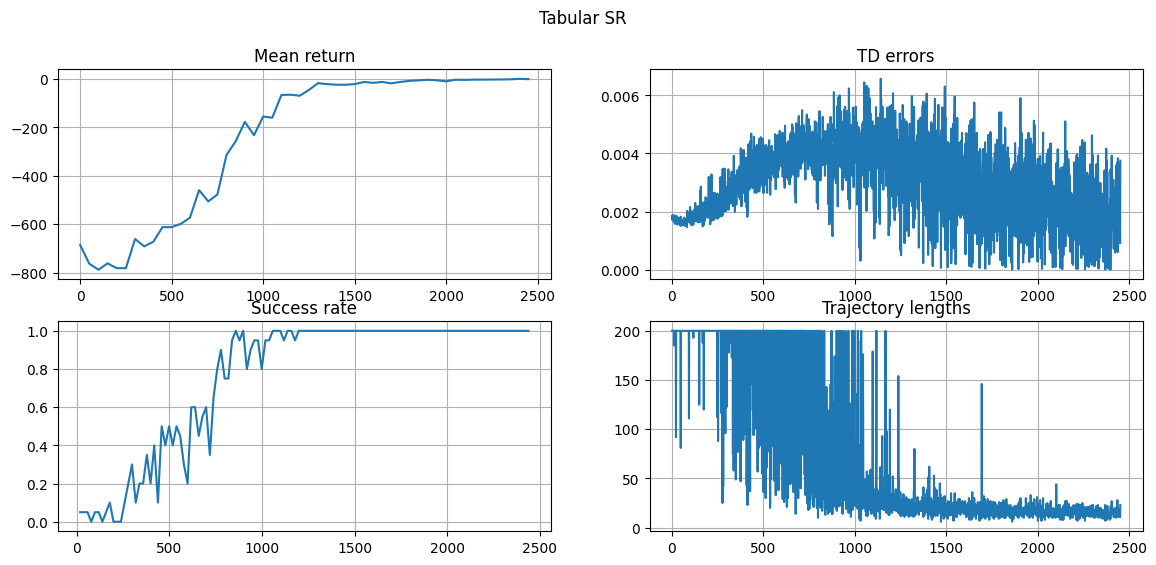

Episode: 2450, Return: -2, AvgReturn[50]: -0


In [363]:
test_stats = trainer.train(num_episodes = 2500)

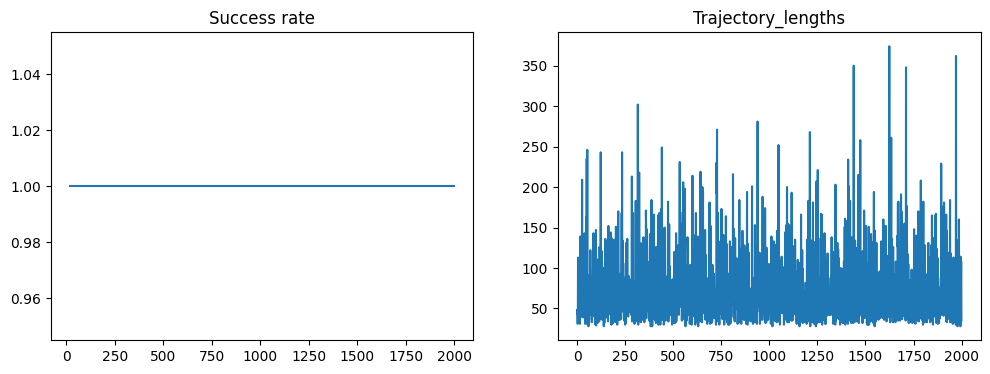

In [207]:
fig, ax = plt.subplots(1,2, figsize = (12,4))
ax[0].plot(*zip(*test_stats["success_rate"]))
ax[0].set_title("Success rate")

ax[1].plot(*zip(*test_stats["trajectory_lengths"]))
ax[1].set_title("Trajectory_lengths")

fig.show()

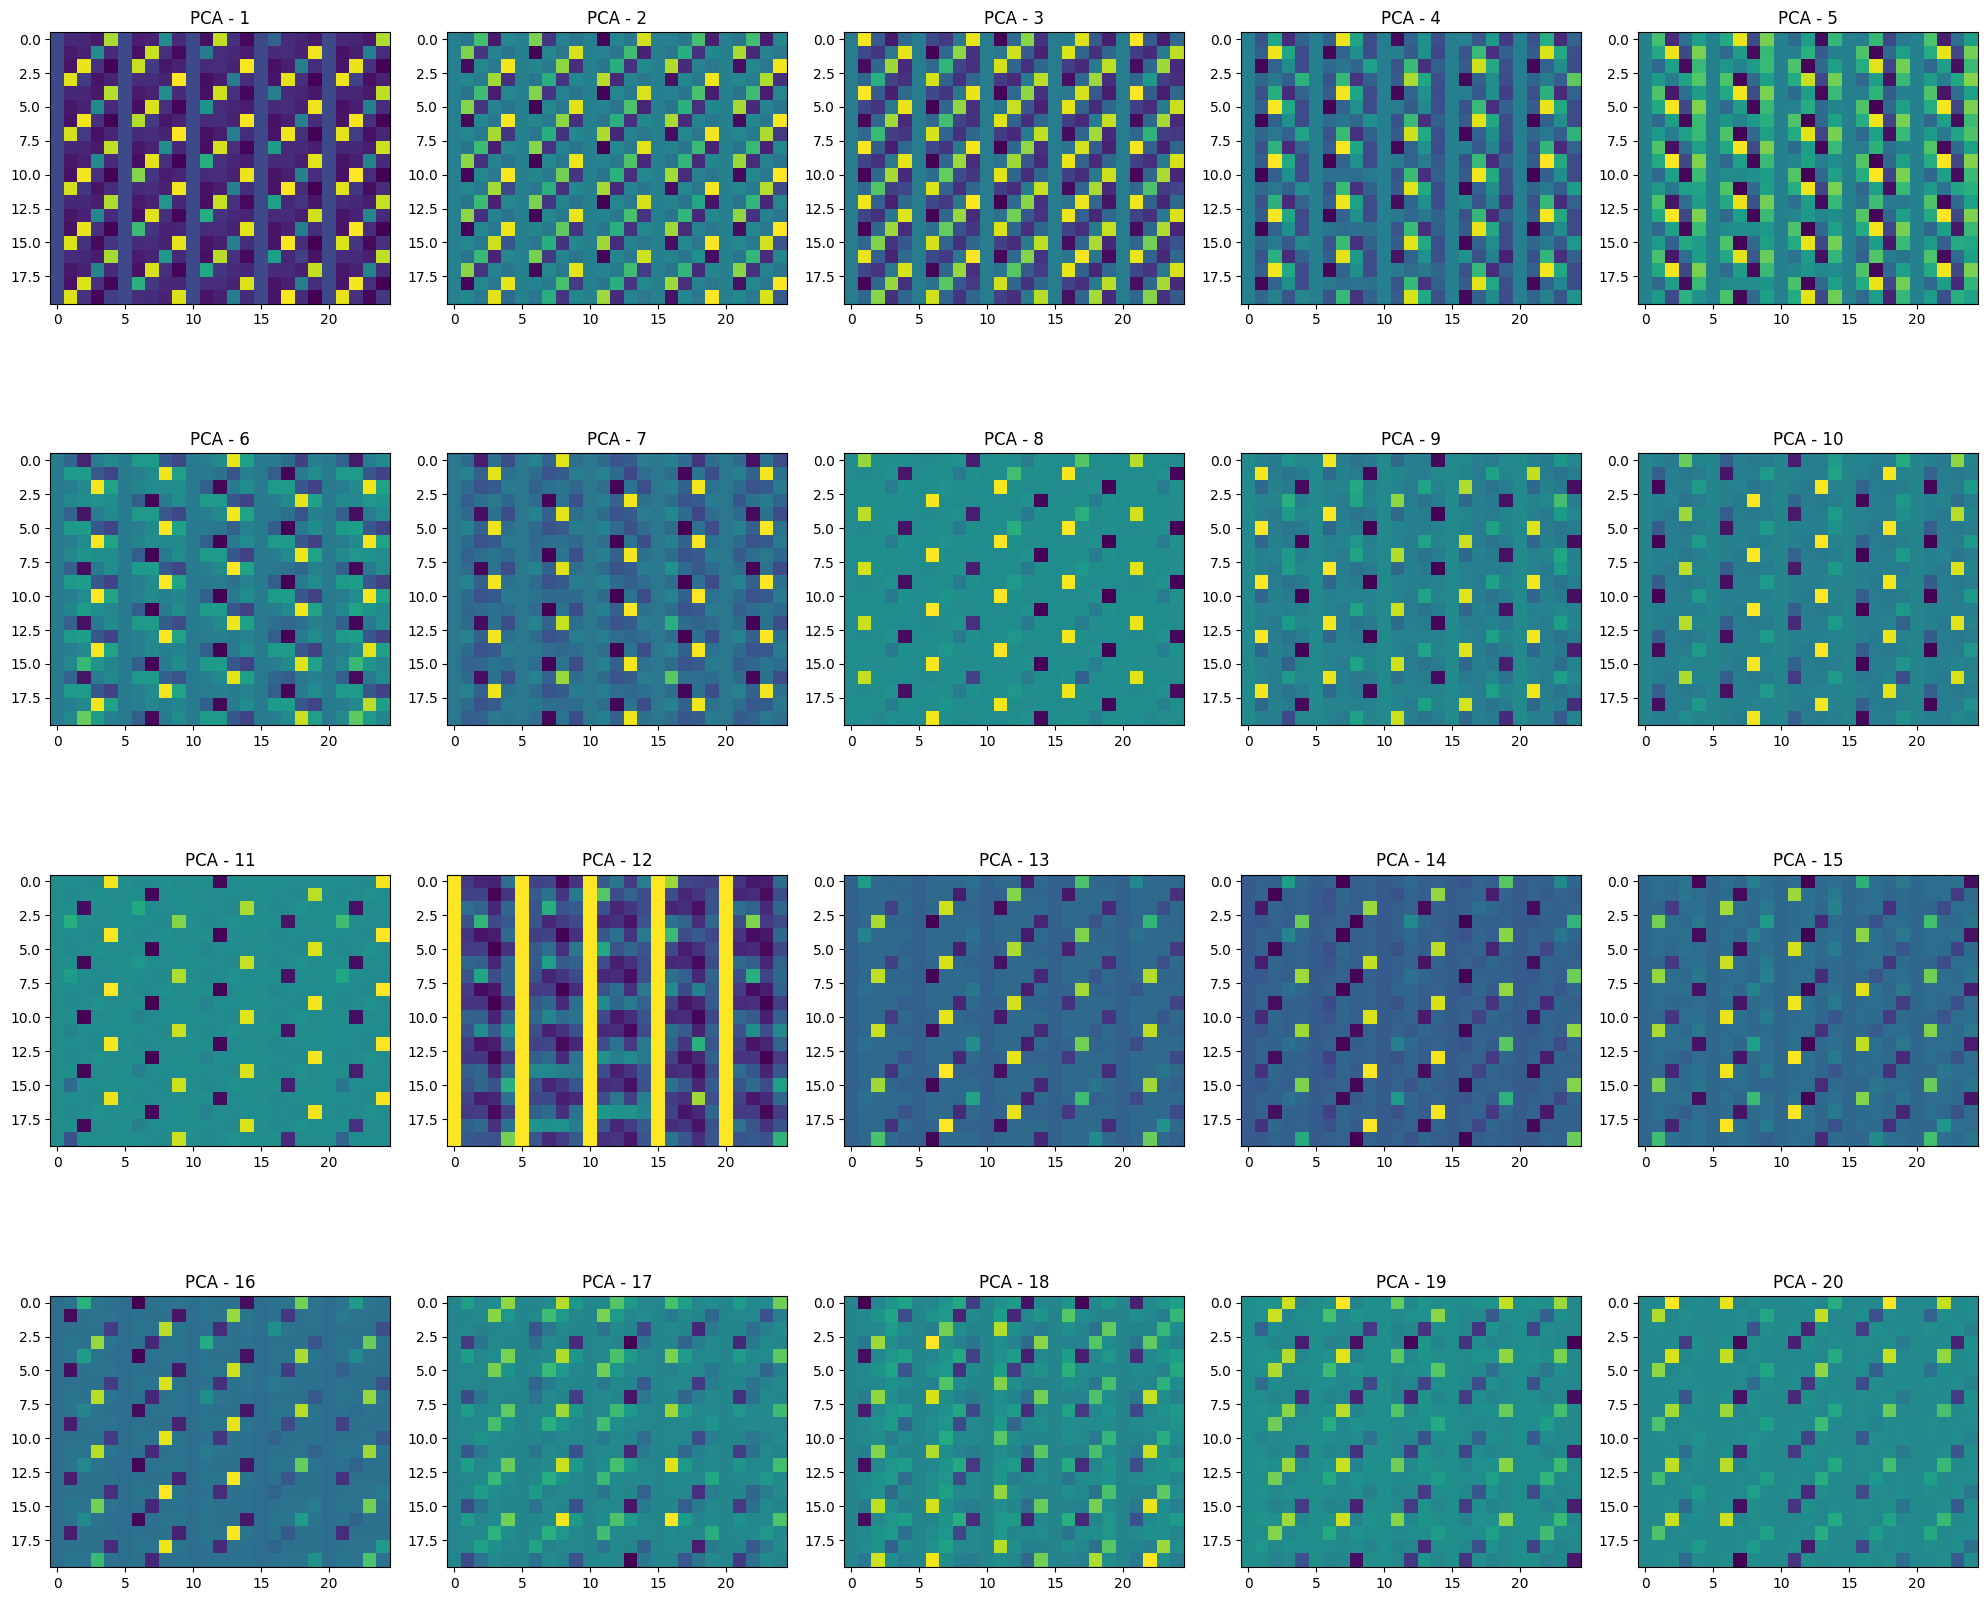

In [196]:
pca = PCA(n_components=100)
pca_M = pca.fit_transform(agent.M.mean(0))

n = 5
m = 4
fig, ax = plt.subplots(m,n, figsize = (20,17))
fig.tight_layout()

for i in range(m):
    for j in range(n):
        ax[i, j].imshow(pca_M[:,i*n + j].reshape(5*4,5*5))
        #ax[i, j].imshow(agent.M.mean(0)[:, i*n + j].reshape(17,16))
        ax[i, j].set_title(f"PCA - {i*n + j+1}")

fig.show()

Text(0.5, 1.0, 'PCA 1 vs 2')

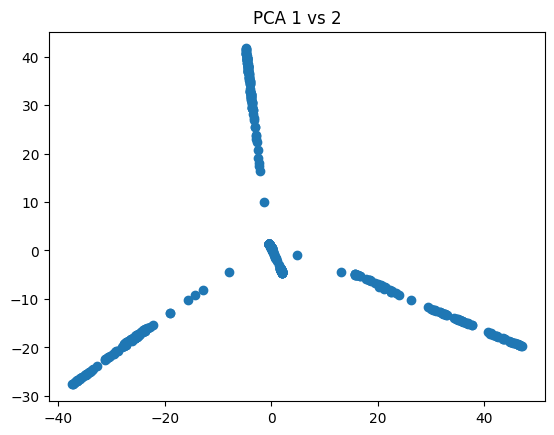

In [198]:
plt.scatter(pca_M[:,1], pca_M[:,2])
plt.title ("PCA 1 vs 2")